In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
%matplotlib notebook

In [3]:

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [4]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf

# Set responsivity filter

In [5]:
# responsive_test = 'nstds'
# responsive_thr = 10.0
# n_stds = 2.5

responsive_test = 'ROC'
responsive_thr = 0.05
n_stds = 0
response_type = 'dff'
traceid= 'traces001'

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
trace_type = optsE.trace_type
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [7]:
stats_str = '%s-%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)

In [8]:
dsets = sdata[sdata['experiment']=='blobs']

always_exclude = ['20190426_JC078']

# Set output dirs

In [9]:
outdir = os.path.join(aggregate_dir, 'linear-separability')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/linear-separability


# Load data

In [10]:
data_dir = os.path.join(aggregate_dir, 'data-stats')
os.listdir(data_dir)

load_data = False
blobsdata_outfile = os.path.join(data_dir, 'blobs_%s-%s_%s-thr-%.2f.pkl' % (traceid, response_type, responsive_test, responsive_thr))
print(blobsdata_outfile)
if os.path.exists(blobsdata_outfile):
    print("...loading data")
    with open(blobsdata_outfile, 'rb') as f:
        NEURALDATA = pkl.load(f)
else:
    load_data = True


/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl
...loading data


In [12]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')
glob.glob(os.path.join(luminance_dir, 'lum-ratios_*'))


['/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis/lum-ratios_M0-M53.pkl']

In [14]:
m0 = 0
m100 = 53
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')
lumratios_datafile = os.path.join(luminance_dir, 'lum-ratios_M%i-M%i.pkl' % (m0, m100))
assert os.path.exists(lumratios_datafile), "LUM-RATIOS NOT FOUND."
with open(lumratios_datafile, 'rb') as f:
    lumdf = pkl.load(f)


In [15]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



## Test with 1 dataset

In [14]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC099' #'JC059'
session = '20190612' #'20190227'
visual_area = 'Li'
fovnum = 1


fov = 'FOV%i_zoom2p0x' % fovnum #'FOV4_zoom4p0x'
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

In [62]:

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C_value = 1.
m0 = 0
m100 = 106

size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2


data_id = '|'.join([animalid, session, fov, traceid, stats_str])

roi_list = [r for r in NEURALDATA[datakey]['data'].columns.tolist() if r != 'config']
sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
sample_labels = NEURALDATA[datakey]['data']['config'].copy()
sdf =  NEURALDATA[datakey]['sdf'].copy()
print(sample_data.shape)
print("N neurons: %i" % len(roi_list))

#stimdf = sdf[sdf['morphlevel'] != -1]
stimdf = sdf.copy()
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())


(1500, 64)
N neurons: 64


In [64]:
#### Test linear separability
# Rust & Dicarlo, 2010.
# 80% of the trials for each trnsformation were combined and used to train; performacne asses with remaining 20%

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [78]:
C_value = 1.0
n_iterations = 50

m0 = 0
m100 = 53

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [m0, m100]
#restrict_transform = True
constant_transform = 'size'

overlap_thr=0.5
luminance_thr=0.8
C_value = 1.0

do_correction = True


n_iterations = 50


In [79]:
#N_samples = {6, 12, 24, 48, 96, 192}
N_samples = {2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120}

In [80]:
too_few=dict((nc, []) for nc in N_samples)

rfdf = []
chance=[]
i = 0
for NCELLS in N_samples:

    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        
        if '%s_%s' % (session, animalid) in always_exclude:
            continue
        
        datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

        sdf =  NEURALDATA[datakey]['sdf'].copy()
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        # Select subset of data
        sample_labels = NEURALDATA[datakey]['data']['config'].copy()
        included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
        sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

        # Get labels
        targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        if do_correction:
            # Get ROIs with RF fits and threshold by lum-ratio
            curr_lumdf = lumdf[lumdf['datakey']==datakey]
            rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
            meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
            lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
            pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

            # Get ROIs with RF fits and threshold by overlap-percentage
            meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
            coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
            pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

            print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
            curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
            print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 
        else:
            curr_rois = np.array([r for r in sample_data.columns.tolist() if r != 'config'])

        if len(curr_rois) < NCELLS:
            too_few[NCELLS].append((datakey, len(curr_rois)))
            continue

        results=[]; test_results=[];
        for iteration in np.arange(0, n_iterations):

            roi_indices = np.arange(0, len(curr_rois))
            np.random.shuffle(roi_indices)
            roi_list = curr_rois[roi_indices[0:NCELLS]]

            sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
            sample_labels = NEURALDATA[datakey]['data']['config'].copy()
            sdf =  NEURALDATA[datakey]['sdf'].copy()

            # First get only Object A and B trials
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
            data = sample_data.loc[included_trial_nums]
            targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (data - data.mean()) / data.std()

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            chance_train_data=[]; chance_test_data=[];
            chance_train_labels=[]; chance_test_labels=[];
            for sz in sizes:
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            #print(train_data.shape, train_labels.shape)
            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)
            #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

            #### Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[iteration]))

            # Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)  
            test_results.append(test_score)

        ddf = pd.concat(results, axis=0)
        results_across_iters = dict(ddf.mean())
        results_across_iters.update({'datakey': datakey, 
                                'n_units': NCELLS, 
                                'visual_area': visual_area,
                                'heldout_test_score': np.mean(test_results)})

        rfdf.append(pd.DataFrame(results_across_iters, index=[i]))
        i+=1

rfdf = pd.concat(rfdf, axis=0)
rfdf.shape





RF-lum-thr: 0/0, Overlap-thr: 0/0
[Li, 20190422_JC076_fov1] 0 rois common to both.
RF-lum-thr: 2/4, Overlap-thr: 3/3
[Li, 20190502_JC076_fov1] 0 rois common to both.
RF-lum-thr: 16/25, Overlap-thr: 0/0
[Li, 20190605_JC090_fov1] 0 rois common to both.
RF-lum-thr: 45/69, Overlap-thr: 5/5
[Li, 20190602_JC091_fov1] 3 rois common to both.
RF-lum-thr: 13/39, Overlap-thr: 2/2
[Li, 20190606_JC091_fov1] 1 rois common to both.
RF-lum-thr: 25/80, Overlap-thr: 2/2
[Li, 20190607_JC091_fov1] 2 rois common to both.
RF-lum-thr: 31/64, Overlap-thr: 3/3
[Li, 20190614_JC091_fov1] 1 rois common to both.
RF-lum-thr: 20/38, Overlap-thr: 2/2
[Li, 20191008_JC091_fov1] 2 rois common to both.
RF-lum-thr: 14/32, Overlap-thr: 2/2
[Li, 20190609_JC099_fov1] 2 rois common to both.
RF-lum-thr: 17/46, Overlap-thr: 1/1
[Li, 20190612_JC099_fov1] 1 rois common to both.
RF-lum-thr: 3/24, Overlap-thr: 0/0
[Li, 20190617_JC099_fov1] 0 rois common to both.
RF-lum-thr: 4/20, Overlap-thr: 2/2
[Li, 20191018_JC113_fov1] 2 rois co

RF-lum-thr: 8/21, Overlap-thr: 5/5
[Lm, 20190627_JC091_fov1] 1 rois common to both.
RF-lum-thr: 27/121, Overlap-thr: 20/20
[V1, 20190420_JC076_fov1] 16 rois common to both.
RF-lum-thr: 17/65, Overlap-thr: 18/18
[V1, 20190501_JC076_fov1] 14 rois common to both.
RF-lum-thr: 65/96, Overlap-thr: 65/65
[V1, 20190507_JC083_fov1] 53 rois common to both.
RF-lum-thr: 28/53, Overlap-thr: 38/38
[V1, 20190510_JC083_fov1] 24 rois common to both.
RF-lum-thr: 40/60, Overlap-thr: 42/42
[V1, 20190511_JC083_fov1] 30 rois common to both.
RF-lum-thr: 83/155, Overlap-thr: 36/36
[V1, 20190522_JC084_fov1] 36 rois common to both.
RF-lum-thr: 123/147, Overlap-thr: 94/94
[V1, 20190622_JC085_fov1] 70 rois common to both.
RF-lum-thr: 89/125, Overlap-thr: 56/56
[V1, 20190613_JC097_fov1] 47 rois common to both.
RF-lum-thr: 114/156, Overlap-thr: 120/120
[V1, 20190616_JC097_fov1] 92 rois common to both.
RF-lum-thr: 118/193, Overlap-thr: 118/118
[V1, 20190617_JC097_fov1] 103 rois common to both.
RF-lum-thr: 53/114, Ov

RF-lum-thr: 4/20, Overlap-thr: 2/2
[Li, 20191018_JC113_fov1] 2 rois common to both.
RF-lum-thr: 1/13, Overlap-thr: 0/0
[Li, 20191105_JC117_fov1] 0 rois common to both.
RF-lum-thr: 5/10, Overlap-thr: 1/1
[Li, 20191111_JC120_fov1] 1 rois common to both.
RF-lum-thr: 38/77, Overlap-thr: 6/6
[Lm, 20190430_JC078_fov1] 5 rois common to both.
RF-lum-thr: 1/2, Overlap-thr: 3/3
[Lm, 20190504_JC078_fov1] 0 rois common to both.
RF-lum-thr: 0/1, Overlap-thr: 3/3
[Lm, 20190509_JC078_fov1] 0 rois common to both.
RF-lum-thr: 10/33, Overlap-thr: 7/7
[Lm, 20190513_JC078_fov1] 4 rois common to both.
RF-lum-thr: 3/5, Overlap-thr: 12/12
[Lm, 20190506_JC080_fov1] 1 rois common to both.
RF-lum-thr: 8/9, Overlap-thr: 15/15
[Lm, 20190603_JC080_fov1] 1 rois common to both.
RF-lum-thr: 48/71, Overlap-thr: 12/12
[Lm, 20190508_JC083_fov1] 7 rois common to both.
RF-lum-thr: 28/55, Overlap-thr: 11/11
[Lm, 20190512_JC083_fov1] 9 rois common to both.
RF-lum-thr: 3/6, Overlap-thr: 7/7
[Lm, 20190517_JC083_fov1] 2 rois c

RF-lum-thr: 53/114, Overlap-thr: 57/57
[V1, 20191006_JC110_fov1] 40 rois common to both.
RF-lum-thr: 0/0, Overlap-thr: 0/0
[Li, 20190422_JC076_fov1] 0 rois common to both.
RF-lum-thr: 2/4, Overlap-thr: 3/3
[Li, 20190502_JC076_fov1] 0 rois common to both.
RF-lum-thr: 16/25, Overlap-thr: 0/0
[Li, 20190605_JC090_fov1] 0 rois common to both.
RF-lum-thr: 45/69, Overlap-thr: 5/5
[Li, 20190602_JC091_fov1] 3 rois common to both.
RF-lum-thr: 13/39, Overlap-thr: 2/2
[Li, 20190606_JC091_fov1] 1 rois common to both.
RF-lum-thr: 25/80, Overlap-thr: 2/2
[Li, 20190607_JC091_fov1] 2 rois common to both.
RF-lum-thr: 31/64, Overlap-thr: 3/3
[Li, 20190614_JC091_fov1] 1 rois common to both.
RF-lum-thr: 20/38, Overlap-thr: 2/2
[Li, 20191008_JC091_fov1] 2 rois common to both.
RF-lum-thr: 14/32, Overlap-thr: 2/2
[Li, 20190609_JC099_fov1] 2 rois common to both.
RF-lum-thr: 17/46, Overlap-thr: 1/1
[Li, 20190612_JC099_fov1] 1 rois common to both.
RF-lum-thr: 3/24, Overlap-thr: 0/0
[Li, 20190617_JC099_fov1] 0 ro

RF-lum-thr: 61/89, Overlap-thr: 16/16
[Lm, 20190525_JC084_fov1] 13 rois common to both.
RF-lum-thr: 8/21, Overlap-thr: 5/5
[Lm, 20190627_JC091_fov1] 1 rois common to both.
RF-lum-thr: 27/121, Overlap-thr: 20/20
[V1, 20190420_JC076_fov1] 16 rois common to both.
RF-lum-thr: 17/65, Overlap-thr: 18/18
[V1, 20190501_JC076_fov1] 14 rois common to both.
RF-lum-thr: 65/96, Overlap-thr: 65/65
[V1, 20190507_JC083_fov1] 53 rois common to both.
RF-lum-thr: 28/53, Overlap-thr: 38/38
[V1, 20190510_JC083_fov1] 24 rois common to both.
RF-lum-thr: 40/60, Overlap-thr: 42/42
[V1, 20190511_JC083_fov1] 30 rois common to both.
RF-lum-thr: 83/155, Overlap-thr: 36/36
[V1, 20190522_JC084_fov1] 36 rois common to both.
RF-lum-thr: 123/147, Overlap-thr: 94/94
[V1, 20190622_JC085_fov1] 70 rois common to both.
RF-lum-thr: 89/125, Overlap-thr: 56/56
[V1, 20190613_JC097_fov1] 47 rois common to both.
RF-lum-thr: 114/156, Overlap-thr: 120/120
[V1, 20190616_JC097_fov1] 92 rois common to both.
RF-lum-thr: 118/193, Overla

RF-lum-thr: 4/20, Overlap-thr: 2/2
[Li, 20191018_JC113_fov1] 2 rois common to both.
RF-lum-thr: 1/13, Overlap-thr: 0/0
[Li, 20191105_JC117_fov1] 0 rois common to both.
RF-lum-thr: 5/10, Overlap-thr: 1/1
[Li, 20191111_JC120_fov1] 1 rois common to both.
RF-lum-thr: 38/77, Overlap-thr: 6/6
[Lm, 20190430_JC078_fov1] 5 rois common to both.
RF-lum-thr: 1/2, Overlap-thr: 3/3
[Lm, 20190504_JC078_fov1] 0 rois common to both.
RF-lum-thr: 0/1, Overlap-thr: 3/3
[Lm, 20190509_JC078_fov1] 0 rois common to both.
RF-lum-thr: 10/33, Overlap-thr: 7/7
[Lm, 20190513_JC078_fov1] 4 rois common to both.
RF-lum-thr: 3/5, Overlap-thr: 12/12
[Lm, 20190506_JC080_fov1] 1 rois common to both.
RF-lum-thr: 8/9, Overlap-thr: 15/15
[Lm, 20190603_JC080_fov1] 1 rois common to both.
RF-lum-thr: 48/71, Overlap-thr: 12/12
[Lm, 20190508_JC083_fov1] 7 rois common to both.
RF-lum-thr: 28/55, Overlap-thr: 11/11
[Lm, 20190512_JC083_fov1] 9 rois common to both.
RF-lum-thr: 3/6, Overlap-thr: 7/7
[Lm, 20190517_JC083_fov1] 2 rois c

(97, 12)

In [81]:
too_few

{2: [('20190422_JC076_fov1', 0),
  ('20190502_JC076_fov1', 0),
  ('20190605_JC090_fov1', 0),
  ('20190606_JC091_fov1', 1),
  ('20190614_JC091_fov1', 1),
  ('20190612_JC099_fov1', 1),
  ('20190617_JC099_fov1', 0),
  ('20191105_JC117_fov1', 0),
  ('20191111_JC120_fov1', 1),
  ('20190504_JC078_fov1', 0),
  ('20190509_JC078_fov1', 0),
  ('20190506_JC080_fov1', 1),
  ('20190603_JC080_fov1', 1),
  ('20190627_JC091_fov1', 1)],
 5: [('20190422_JC076_fov1', 0),
  ('20190502_JC076_fov1', 0),
  ('20190605_JC090_fov1', 0),
  ('20190602_JC091_fov1', 3),
  ('20190606_JC091_fov1', 1),
  ('20190607_JC091_fov1', 2),
  ('20190614_JC091_fov1', 1),
  ('20191008_JC091_fov1', 2),
  ('20190609_JC099_fov1', 2),
  ('20190612_JC099_fov1', 1),
  ('20190617_JC099_fov1', 0),
  ('20191018_JC113_fov1', 2),
  ('20191105_JC117_fov1', 0),
  ('20191111_JC120_fov1', 1),
  ('20190504_JC078_fov1', 0),
  ('20190509_JC078_fov1', 0),
  ('20190513_JC078_fov1', 4),
  ('20190506_JC080_fov1', 1),
  ('20190603_JC080_fov1', 1),
  (

In [82]:
roicounts=[]
passrois = []
i=0
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    if '%s_%s' % (session, animalid) in always_exclude:
        continue

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    sdf =  NEURALDATA[datakey]['sdf'].copy()
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    # Get ROIs with RF fits and threshold by lum-ratio
    visual_rois = np.array([int(r) for r in NEURALDATA[datakey]['data'].columns if r!='config'])
    curr_lumdf = lumdf[lumdf['datakey']==datakey]
    rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
    meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
    lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
    pass_rois_lum = [r for r in lum_rois if r in visual_rois]

    # Get ROIs with RF fits and threshold by overlap-percentage
    meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
    coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
    pass_rois_overlap = [r for r in coverage_rois if r in visual_rois]

    print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
    curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
    print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 

    nrs = len(curr_rois)
    passrois.append(pd.DataFrame({'rois': curr_rois,
                                  'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                  'datakey': [datakey for _ in np.arange(0, nrs)]}))
    
    roicounts.append(pd.DataFrame({'visual': len(visual_rois),
                                   'pass_luminance': len(pass_rois_lum),
                                   'pass_overlap': len(pass_rois_overlap),
                                   'visual_area': visual_area,
                                   'datakey': datakey}, index=[i]))
    i+=1
    
roicounts = pd.concat(roicounts, axis=0)

RF-lum-thr: 0/0, Overlap-thr: 0/0
[Li, 20190422_JC076_fov1] 0 rois common to both.
RF-lum-thr: 2/4, Overlap-thr: 3/3
[Li, 20190502_JC076_fov1] 0 rois common to both.
RF-lum-thr: 16/25, Overlap-thr: 0/0
[Li, 20190605_JC090_fov1] 0 rois common to both.
RF-lum-thr: 45/69, Overlap-thr: 5/5
[Li, 20190602_JC091_fov1] 3 rois common to both.
RF-lum-thr: 13/39, Overlap-thr: 2/2
[Li, 20190606_JC091_fov1] 1 rois common to both.
RF-lum-thr: 25/80, Overlap-thr: 2/2
[Li, 20190607_JC091_fov1] 2 rois common to both.
RF-lum-thr: 31/64, Overlap-thr: 3/3
[Li, 20190614_JC091_fov1] 1 rois common to both.
RF-lum-thr: 20/38, Overlap-thr: 2/2
[Li, 20191008_JC091_fov1] 2 rois common to both.
RF-lum-thr: 14/32, Overlap-thr: 2/2
[Li, 20190609_JC099_fov1] 2 rois common to both.
RF-lum-thr: 17/46, Overlap-thr: 1/1
[Li, 20190612_JC099_fov1] 1 rois common to both.
RF-lum-thr: 3/24, Overlap-thr: 0/0
[Li, 20190617_JC099_fov1] 0 rois common to both.
RF-lum-thr: 4/20, Overlap-thr: 2/2
[Li, 20191018_JC113_fov1] 2 rois co

In [83]:
rfdf.head()

,datakey,fit_time,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,20190602_JC091_fov1,0.003716,0.498333,2,0.000394,0.507415,-1383.671970,-0.972202,0.539806,-1292.684397,-0.842406,Li
1,20190607_JC091_fov1,0.004789,0.529667,2,0.000368,0.554940,-1250.173117,-0.781832,0.571894,-1202.548706,-0.713858,Li
2,20191008_JC091_fov1,0.012485,0.492308,2,0.000417,0.514441,-1363.936029,-0.943303,0.522725,-1340.664892,-0.910109,Li
3,20190609_JC099_fov1,0.003284,0.558000,2,0.000354,0.557643,-1242.579791,-0.771381,0.572018,-1202.200680,-0.713740,Li
4,20191018_JC113_fov1,0.008884,0.491579,2,0.000403,0.510574,-1374.797056,-0.958582,0.526683,-1329.548128,-0.894055,Li


In [84]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

In [85]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/linear-separability'

In [86]:
lumdir = os.path.join(aggregate_dir, 'luminance-analysis')


<IPython.core.display.Javascript object>


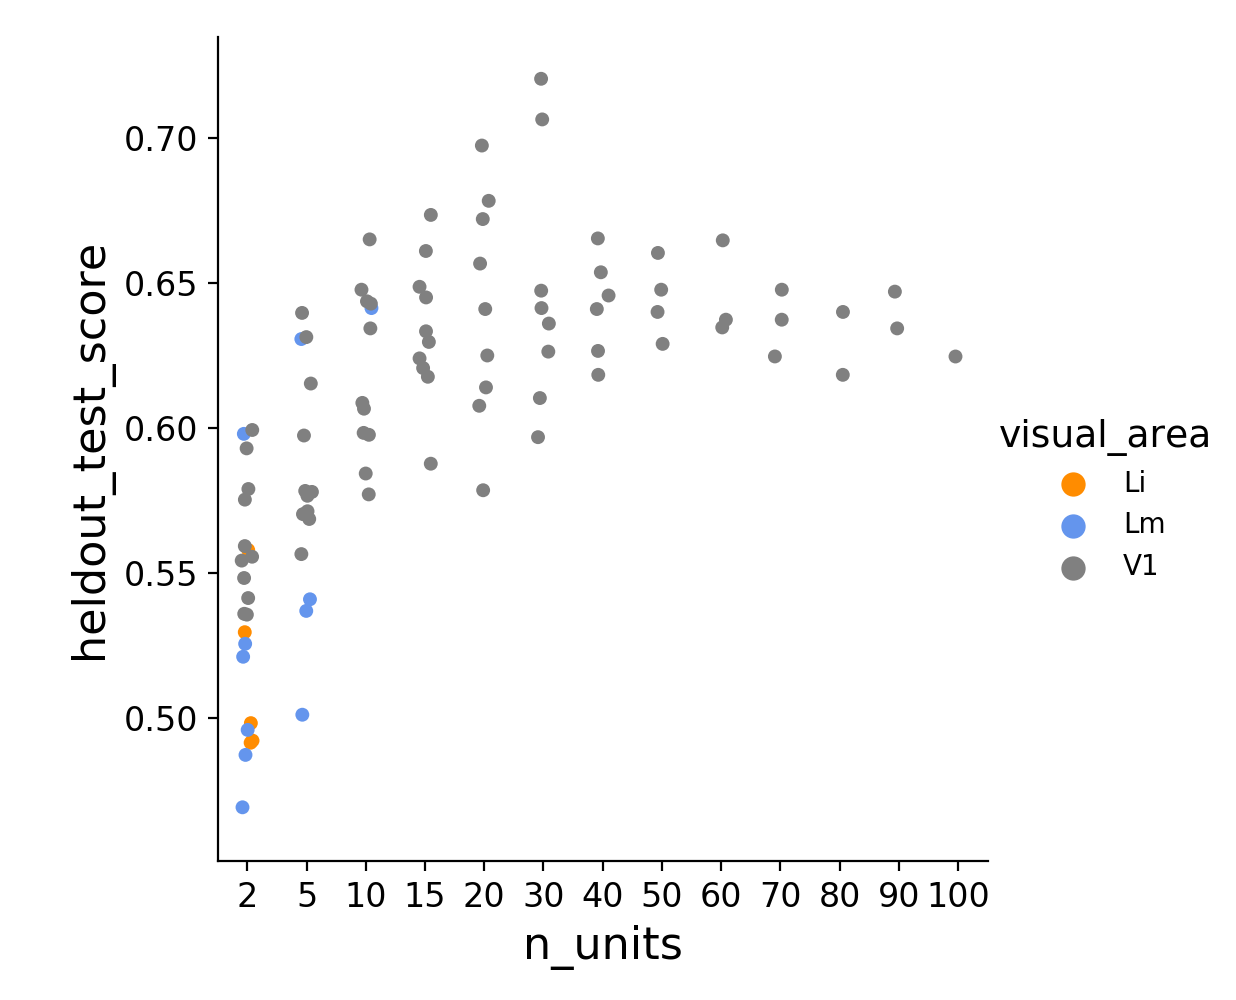

lin-sep_population_test-acc-by-N-units_C1.00_filtered-lum-0.80-overlap-0.50


In [87]:
sns.catplot(x='n_units', y='heldout_test_score', hue='visual_area', palette=area_colors, data=rfdf)


figname = 'lin-sep_population_test-acc-by-N-units_C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


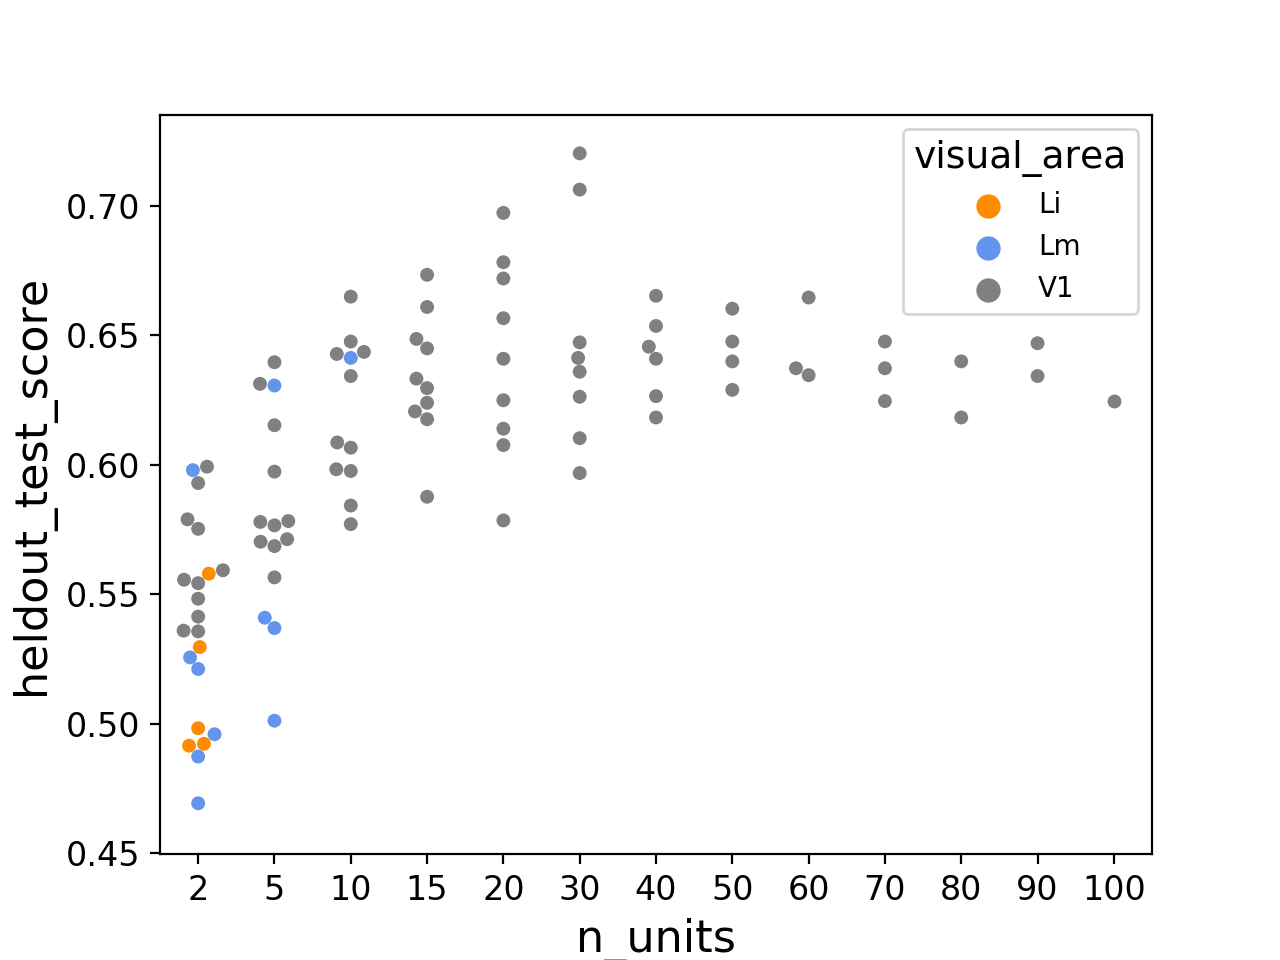

In [88]:
fig, ax = pl.subplots()
sns.swarmplot(x='n_units', y='heldout_test_score', hue='visual_area', palette=area_colors, data=rfdf, ax=ax)

figname = 'lin-sep_population_test-acc-by-N-units_C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))
pl.savefig(os.path.join(lumdir, '%s.png' % figname))


<IPython.core.display.Javascript object>


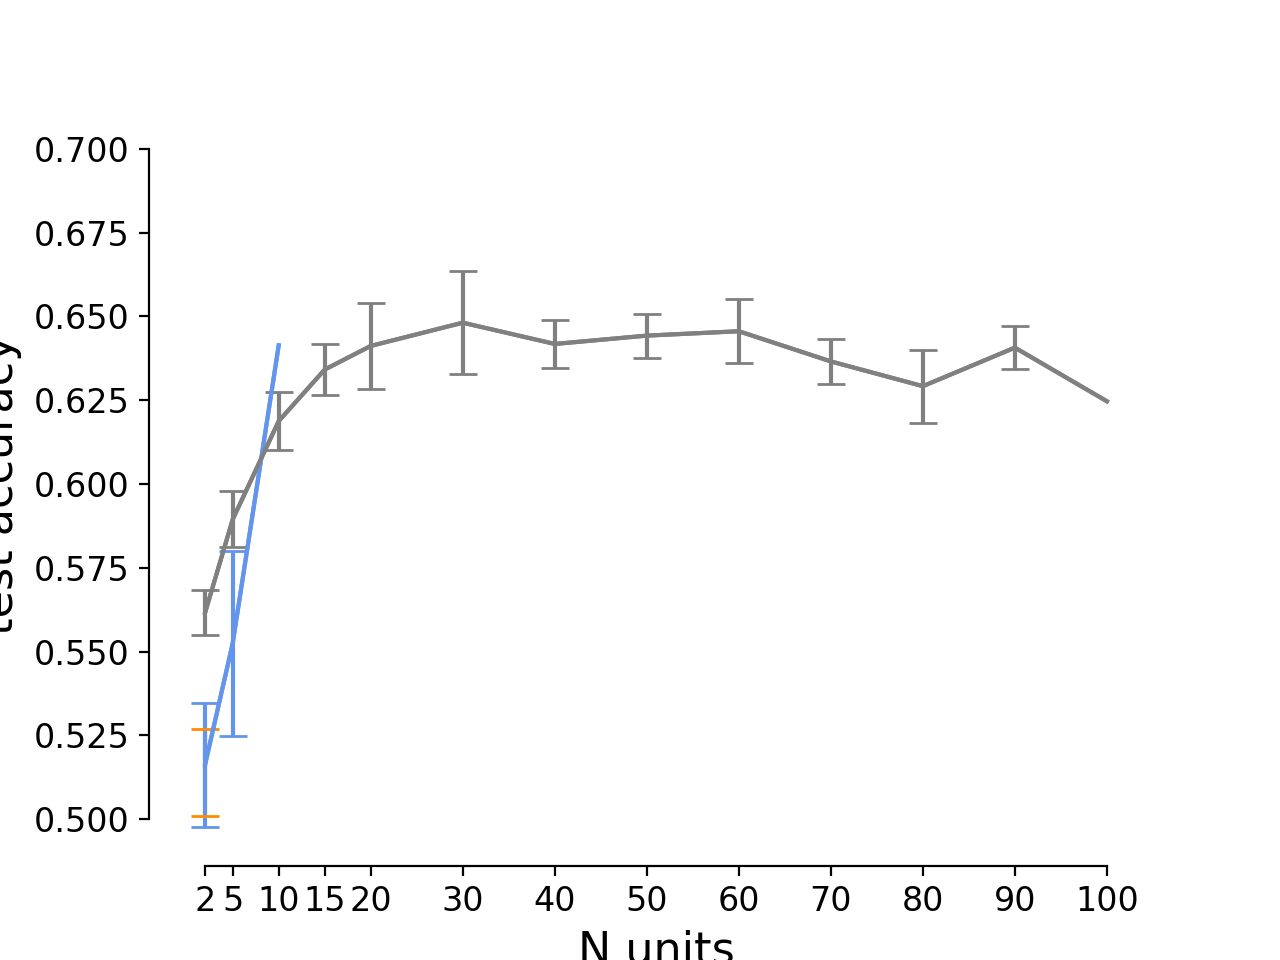

lin-sep_population_test-acc-by-N-units_C1.00_filtered-lum-0.80-overlap-0.50_mean


In [89]:
fig, ax = pl.subplots()
for visual_area, g in rfdf.groupby(['visual_area']):
    mean_scores = g.groupby(['n_units'])['heldout_test_score'].mean()
    std_scores = g.groupby(['n_units'])['heldout_test_score'].apply(spstats.sem, nan_policy='omit')
    n_units_per = g.groupby(['n_units'])['heldout_test_score'].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area])
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], capsize=5)

ax.set_xticks(n_units_per)
ax.set_xticklabels(n_units_per)
ax.set_xlabel("N units")
ax.set_ylabel("test accuracy")
ax.set_ylim([ax.get_ylim()[0], 0.71])
sns.despine(trim=True, offset=4)

figname = 'lin-sep_population_test-acc-by-N-units_C%.2f_filtered-lum-%.2f-overlap-%.2f_mean' % (C_value, luminance_thr, overlap_thr)
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))
pl.savefig(os.path.join(lumdir, '%s.png' % figname))
print(figname)


In [37]:
g['test_accuracy'].mean()

0.6083593713983062

In [39]:
g.groupby(['n_units'])['heldout_test_score'].mean()

n_units
2      0.555485
5      0.590424
10     0.608355
15     0.620325
20     0.636305
30     0.639780
40     0.647512
50     0.648444
60     0.648111
70     0.649333
80     0.648533
90     0.628889
100    0.626667
Name: heldout_test_score, dtype: float64

In [97]:
m0 = 0
m100 = 106

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [m0,  m100]
restrict_transform = True
constant_transform = 'size'

n_iterations = 50
lw=2


overlap_thr=0.25
luminance_thr=0.8
C_value = 1.0

do_correction = True


#train_transform = 30.

### test run

In [ ]:

do_correction = True

i = 0
rfdf=[]
no_cells=[]

split_results = {}
R = {}

In [71]:


print(datakey)
#datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

sdf =  NEURALDATA[datakey]['sdf'].copy()
object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
sizes = sorted(stimdf['size'].unique())

# Select subset of data
sample_labels = NEURALDATA[datakey]['data']['config'].copy()
included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

# Get labels
targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

if do_correction:
    # Get ROIs with RF fits and threshold by lum-ratio
    curr_lumdf = lumdf[lumdf['datakey']==datakey]
    rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
    meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
    lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
    pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

    # Get ROIs with RF fits and threshold by overlap-percentage
    meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
    coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
    pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

    print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
    curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
    print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 
else:
    curr_rois = [r for r in sample_data.columns]


20191006_JC110_fov1
RF-lum-thr: 53/114, Overlap-thr: 78/78
[V1, 20191006_JC110_fov1] 47 rois common to both.


In [85]:

#NCELLS = len(curr_rois)
# if NCELLS == 0:
#     no_cells.append(datakey)
#     continue

#### Train on 1 size, test on other sizes - repeat 50 times.
#R={}
for train_transform in sizes:
    split_test_scores = dict((tv, []) for tv in sizes)

    print(train_transform)
    if train_transform not in R.keys():
        R[train_transform] = {}

    results=[]; test_results=[]; gen_test_results=[];
    for iteration in np.arange(0, n_iterations):

        roi_indices = np.arange(0, len(curr_rois))
        np.random.shuffle(roi_indices)
        roi_list = curr_rois[roi_indices[0:NCELLS]]

        sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
        sample_labels = NEURALDATA[datakey]['data']['config'].copy()
        sdf =  NEURALDATA[datakey]['sdf'].copy()

        # First get only Object A and B trials
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
        data = sample_data.loc[included_trial_nums]
        targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        # Equalize df/f across neurons:  Normalize each neuron to have 
        # the same (zero) mean and (unit) SD across the Ms stimuli
        zdata = (data - data.mean()) / data.std()
        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        # ---- Get train configs (restricted to size) ----
        train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                & (stimdf[constant_transform]==train_transform))].index.tolist()

        # ---- Get corresponding trials ----
        curr_trials = np.array(targets[targets['config'].isin(train_configs)].index.tolist())

        # ---- Get data and labels ----
        xi = zdata.loc[curr_trials].values #[train_configs]
        yi = targets.loc[curr_trials]['label'].values

        # ---- Split train/validate from heldout test ----
        train_data, test_data, train_labels, test_labels = train_test_split(xi, yi, test_size=0.2)

        # ---- ALSO, get "generalization" test set ----
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                               & (stimdf[class_name].isin(class_types)) )].index.tolist()

        #gen_test_trials = [i for i, l in enumerate(sample_labels) if l in test_configs]
        gen_test_trials = np.array(targets[targets['config'].isin(test_configs)].index.tolist())
        gen_test_data = zdata.loc[gen_test_trials].values
        gen_test_labels = targets.loc[gen_test_trials]['label'].values
        test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

        #### Train and cross validate
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())
        results.append(pd.DataFrame(iterdict, index=[iteration]))

        #### Test with held-out data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)  
        test_results.append(test_score)

        split_test_scores[train_transform].append(test_score)

        #### Test with generalization data
        gen_test_score = trained_svc.score(gen_test_data, gen_test_labels)
        gen_test_results.append(gen_test_score)

        ### Split Gen-Test (generalization) by size...
        gen_test_configs_on_trial = targets.loc[gen_test_trials]['config'].values
        for test_transform in test_transforms:
            curr_test_ixs = [i for i, tl in enumerate(gen_test_configs_on_trial)\
                             if stimdf[constant_transform][tl]==test_transform]

            gen_test_xi = gen_test_data[curr_test_ixs, :]
            gen_test_yi = [stimdf['morphlevel'][tc] for tc in gen_test_configs_on_trial[curr_test_ixs]]
            curr_gen_test_score = trained_svc.score(gen_test_xi, gen_test_yi)
            split_test_scores[test_transform].append(curr_gen_test_score)
            
    #split_test_scores[test_transform] = gen_test_scores_by_iter
    R[train_transform][datakey] = split_test_scores
    ddf = pd.concat(results, axis=0) # Get mean across all iterations
    results_across_iters = dict(ddf.mean())
    results_across_iters.update({'datakey': datakey, 
                            'n_units': NCELLS, 
                            'visual_area': visual_area,
                            'heldout_test_score': np.mean(test_results),
                            'gen_test_score': np.mean(gen_test_results),
                             'train_size': train_transform})

    rfdf.append(pd.DataFrame(results_across_iters, index=[i]))
    i+=1

    #split_results[datakey] = split_test_scores
    R[train_transform][datakey] = split_test_scores

        

10.0
20.0
30.0
40.0
50.0


In [86]:
len(split_test_scores[10])


50

In [96]:

for i in sizes:
    print(i, np.mean(R[50]['20191006_JC110_fov1'][i]))


(10.0, 0.48147058823529415)
(20.0, 0.55522388059701488)
(30.0, 0.57558823529411762)
(40.0, 0.5797014925373134)
(50.0, 0.64857142857142858)


In [95]:
rfdf[0]

,datakey,fit_time,gen_test_score,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,train_size,visual_area
268,20191006_JC110_fov1,0.000713,0.486766,0.59,30,0.000369,0.587285,-4637.267442,-0.657867,0.997803,-24.681192,0.991185,10.0,V1


# DO IT ALL

In [103]:
m0 = 0
m100 = 53

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [m0,  m100]
restrict_transform = True
constant_transform = 'size'

n_iterations = 50
lw=2


overlap_thr=0.25
luminance_thr=0.8
C_value = 1.0

do_correction = True

if do_correction:
    filter_str = 'C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
else:
    filter_str = 'none'
print(filter_str)

C1.00_filtered-lum-0.80-overlap-0.25


In [ ]:
testgen_dfile = os.path.join(lumdir, 'generalization-results_%s.pkl' % filter_str)
rungen_ = False
if os.path.exists(testgen_file):
    with open(testgen_file, 'rb') as f:
        gresults = pkl.load(f)
    R = gresults['R']
    rfdf = gresults['rfdf']
else:
    rungen_ = True
print(rungen_)
    

In [100]:
do_correction = True

i = 0
rfdf=[]
no_cells=[]

split_results = {}
R = {}

for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    print(datakey)
    #datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    sdf =  NEURALDATA[datakey]['sdf'].copy()
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    # Select subset of data
    sample_labels = NEURALDATA[datakey]['data']['config'].copy()
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

    # Get labels
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    if do_correction:
        # Get ROIs with RF fits and threshold by lum-ratio
        curr_lumdf = lumdf[lumdf['datakey']==datakey]
        rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
        meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
        lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
        pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

        # Get ROIs with RF fits and threshold by overlap-percentage
        meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

        print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 
    else:
        curr_rois = [r for r in sample_data.columns]


    NCELLS = len(curr_rois)
    if NCELLS == 0:
        no_cells.append(datakey)
        continue

    #### Train on 1 size, test on other sizes - repeat 50 times.
    for train_transform in sizes:
        split_test_scores = dict((tv, []) for tv in sizes)

        #print(train_transform)
        if train_transform not in R.keys():
            R[train_transform] = {}

        results=[]; test_results=[]; gen_test_results=[];
        for iteration in np.arange(0, n_iterations):

            roi_indices = np.arange(0, len(curr_rois))
            np.random.shuffle(roi_indices)
            roi_list = curr_rois[roi_indices[0:NCELLS]]

            sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
            sample_labels = NEURALDATA[datakey]['data']['config'].copy()
            sdf =  NEURALDATA[datakey]['sdf'].copy()

            # First get only Object A and B trials
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
            data = sample_data.loc[included_trial_nums]
            targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (data - data.mean()) / data.std()
            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            # ---- Get train configs (restricted to size) ----
            train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                    & (stimdf[constant_transform]==train_transform))].index.tolist()

            # ---- Get corresponding trials ----
            curr_trials = np.array(targets[targets['config'].isin(train_configs)].index.tolist())

            # ---- Get data and labels ----
            xi = zdata.loc[curr_trials].values #[train_configs]
            yi = targets.loc[curr_trials]['label'].values

            # ---- Split train/validate from heldout test ----
            train_data, test_data, train_labels, test_labels = train_test_split(xi, yi, test_size=0.2)

            # ---- ALSO, get "generalization" test set ----
            untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
            test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                                   & (stimdf[class_name].isin(class_types)) )].index.tolist()

            #gen_test_trials = [i for i, l in enumerate(sample_labels) if l in test_configs]
            gen_test_trials = np.array(targets[targets['config'].isin(test_configs)].index.tolist())
            gen_test_data = zdata.loc[gen_test_trials].values
            gen_test_labels = targets.loc[gen_test_trials]['label'].values
            test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

            #### Train and cross validate
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[iteration]))

            #### Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)  
            test_results.append(test_score)

            split_test_scores[train_transform].append(test_score)

            #### Test with generalization data
            gen_test_score = trained_svc.score(gen_test_data, gen_test_labels)
            gen_test_results.append(gen_test_score)

            ### Split Gen-Test (generalization) by size...
            gen_test_configs_on_trial = targets.loc[gen_test_trials]['config'].values
            for test_transform in test_transforms:
                curr_test_ixs = [i for i, tl in enumerate(gen_test_configs_on_trial)\
                                 if stimdf[constant_transform][tl]==test_transform]

                gen_test_xi = gen_test_data[curr_test_ixs, :]
                gen_test_yi = [stimdf['morphlevel'][tc] for tc in gen_test_configs_on_trial[curr_test_ixs]]
                curr_gen_test_score = trained_svc.score(gen_test_xi, gen_test_yi)
                split_test_scores[test_transform].append(curr_gen_test_score)

        #split_test_scores[test_transform] = gen_test_scores_by_iter
        R[train_transform][datakey] = split_test_scores
        ddf = pd.concat(results, axis=0) # Get mean across all iterations
        results_across_iters = dict(ddf.mean())
        results_across_iters.update({'datakey': datakey, 
                                'n_units': NCELLS, 
                                'visual_area': visual_area,
                                'heldout_test_score': np.mean(test_results),
                                'gen_test_score': np.mean(gen_test_results),
                                 'train_size': train_transform})

        rfdf.append(pd.DataFrame(results_across_iters, index=[i]))
        i+=1

        #split_results[datakey] = split_test_scores
        R[train_transform][datakey] = split_test_scores


rfdf = pd.concat(rfdf, axis=0)
rfdf.shape


# Save
gresults = {'R': R, 'rfdf': rfdf}
with open(testgen_dfile, 'wb') as f:
    pkl.dump(gresults, f, protocol=pkl.HIGHEST_PROTOCOL)
    

20190422_JC076_fov1
RF-lum-thr: 0/0, Overlap-thr: 0/0
[Li, 20190422_JC076_fov1] 0 rois common to both.
20190502_JC076_fov1
RF-lum-thr: 2/4, Overlap-thr: 14/14
[Li, 20190502_JC076_fov1] 2 rois common to both.
20190605_JC090_fov1
RF-lum-thr: 16/25, Overlap-thr: 10/10
[Li, 20190605_JC090_fov1] 9 rois common to both.
20190602_JC091_fov1
RF-lum-thr: 45/69, Overlap-thr: 40/40
[Li, 20190602_JC091_fov1] 21 rois common to both.
20190606_JC091_fov1
RF-lum-thr: 13/39, Overlap-thr: 14/14
[Li, 20190606_JC091_fov1] 11 rois common to both.
20190607_JC091_fov1
RF-lum-thr: 25/80, Overlap-thr: 27/27
[Li, 20190607_JC091_fov1] 20 rois common to both.
20190614_JC091_fov1
RF-lum-thr: 31/64, Overlap-thr: 38/38
[Li, 20190614_JC091_fov1] 22 rois common to both.
20191008_JC091_fov1
RF-lum-thr: 20/38, Overlap-thr: 9/9
[Li, 20191008_JC091_fov1] 7 rois common to both.
20190609_JC099_fov1
RF-lum-thr: 14/32, Overlap-thr: 20/20
[Li, 20190609_JC099_fov1] 13 rois common to both.
20190612_JC099_fov1
RF-lum-thr: 17/46, O

(160, 14)

In [104]:
testgen_dfile = os.path.join(lumdir, 'generalization-results_%s.pkl' % filter_str)
gresults = {'R': R, 'rfdf': rfdf}
with open(testgen_dfile, 'wb') as f:
    pkl.dump(gresults, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [106]:
tested_sizes = sizes

## Plot generalization performance

<IPython.core.display.Javascript object>


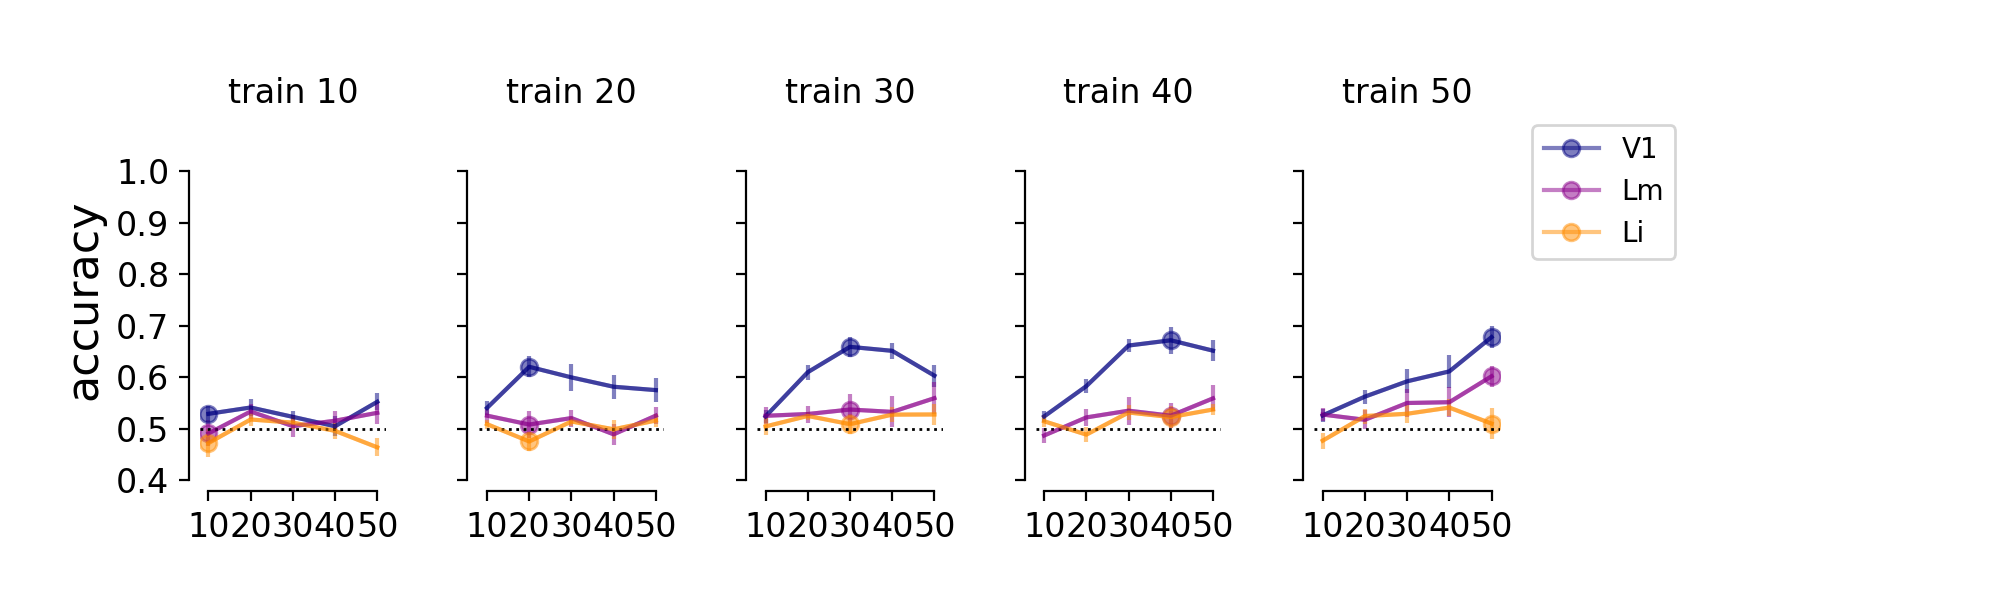

test-generalization_split-train-1-sz-test-others_M0-v-M53__boot-train_C1.00_filtered-lum-0.80-overlap-0.25_


In [158]:
norm_to_trained = False

fig, axes = pl.subplots(1, len(tested_sizes), figsize=(10,3), sharex=True, sharey=True)

for si in range(len(tested_sizes)):
    curr_results = R[tested_sizes[si]]
    ax = axes[si]

    meanscores = dict((visual_area, []) for visual_area in visual_areas)
    for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):

        #data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

        if datakey not in curr_results.keys():
            continue
        test_scores = curr_results[datakey]
        meanvs = [np.mean(test_scores[k]) for k in tested_sizes]
        meanscores[visual_area].append(meanvs)

    for visual_area in visual_areas:
        meanscores[visual_area] = np.array(meanscores[visual_area]) # rows = n datakeys, cols = n sizes
        means = meanscores[visual_area].mean(axis=0)
        sems = spstats.sem(meanscores[visual_area], axis=0)

        if norm_to_trained:
            train_score = means[si]
            means = means / train_score # means.max()
            print(means.max())
            ylabel = 'normed (train acc.)'
        else:
            ylabel = 'accuracy'

        ax.plot(tested_sizes, means, color=area_colors[visual_area], alpha=0.5)
        ax.plot(tested_sizes[si], means[si], color=area_colors[visual_area], marker='o', label=visual_area, alpha=0.5)
        ax.errorbar(tested_sizes, means, yerr=sems, color=area_colors[visual_area], alpha=0.5)

        ax.set_ylim([0.4, 1.1])
        ax.set_xticks(tested_sizes)
        ax.set_yticks([round(v, 1) for v in np.linspace(0.4, 1.0, 7)])
        #ax.set_
        ax.set_xticklabels([int(i) for i in tested_sizes])
        sns.despine(ax=ax, trim=True, offset=4)
    ax.set_title('train %i' % tested_sizes[si])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')
    if si == 0:
        ax.set_ylabel(ylabel)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1, right=0.75, bottom=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.8))
normstr = 'normalized' if norm_to_trained else ''

    
figname = 'test-generalization_split-train-1-sz-test-others_M%i-v-M%i__boot-train_%s_%s' % (m0, m100, filter_str, normstr)
print(figname)

pl.savefig(os.path.join(lumdir, '%s_bmo.png' % figname)) 
pl.savefig(os.path.join(lumdir, '%s_bmo.svg' % figname))


In [120]:
curr_results.keys()

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1',
 '20190609_JC099_fov1',
 '20191111_JC120_fov1',
 '20190517_JC083_fov1',
 '20190613_JC097_fov1',
 '20191018_JC113_fov1',
 '20190622_JC085_fov1',
 '20190501_JC076_fov1',
 '20191008_JC091_fov1',
 '20190606_JC091_fov1',
 '20190605_JC090_fov1',
 '20190602_JC091_fov1',
 '20190507_JC083_fov1',
 '20190614_JC091_fov1',
 '20190616_JC097_fov1',
 '20190508_JC083_fov1',
 '20190612_JC099_fov1',
 '20190617_JC097_fov1',
 '20190511_JC083_fov1',
 '20190430_JC078_fov1',
 '20191006_JC110_fov1',
 '20190525_JC084_fov1',
 '20190607_JC091_fov1',
 '20190522_JC084_fov1',
 '20190617_JC099_fov1',
 '20190627_JC091_fov1',
 '20190513_JC078_fov1',
 '20190502_JC076_fov1']

In [153]:
tlist = []
for train_sz, curr_results in R.items():
    tdf = pd.concat([pd.DataFrame({'test_score': [np.mean(test_scores[k]) for k in tested_sizes],
                     'test_size': [k for k in tested_sizes],
                     'train_size': [train_sz for _ in np.arange(0, len(tested_sizes))],
                     'datakey': [datakey for _ in np.arange(0, len(tested_sizes))]}) \
                     for datakey, test_scores in curr_results.items()], axis=0)
    tdf['visual_area'] = [dsets[(dsets['session']==s.split('_')[0]) \
                           & (dsets['animalid']==s.split('_')[1]) \
                           & (dsets['fovnum']==int(s.split('_')[2][3:]))]['visual_area'].unique()[0] \
                           for s in tdf['datakey'].values]
    tlist.append(tdf)
tdf = pd.concat(tlist, axis=0).reset_index(drop=True)


In [154]:
tdf['rel_score'] = [-1.0 for _ in np.arange(0, tdf.shape[0])]
for (datakey, train_sz), g in tdf.groupby(['datakey', 'train_size']):
    ref_score = float(g[g['test_size']==train_sz]['test_score'])
    rel_scores = g['test_score'] / ref_score
    tdf['rel_score'][g.index] = rel_scores

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [155]:
tdf.head()

,datakey,test_score,test_size,train_size,visual_area,rel_score
0,20190512_JC083_fov1,0.436250,10.0,40.0,Lm,0.764319
1,20190512_JC083_fov1,0.518710,20.0,40.0,Lm,0.908791
2,20190512_JC083_fov1,0.674603,30.0,40.0,Lm,1.181919
3,20190512_JC083_fov1,0.570769,40.0,40.0,Lm,1.000000
4,20190512_JC083_fov1,0.603548,50.0,40.0,Lm,1.057430


<IPython.core.display.Javascript object>


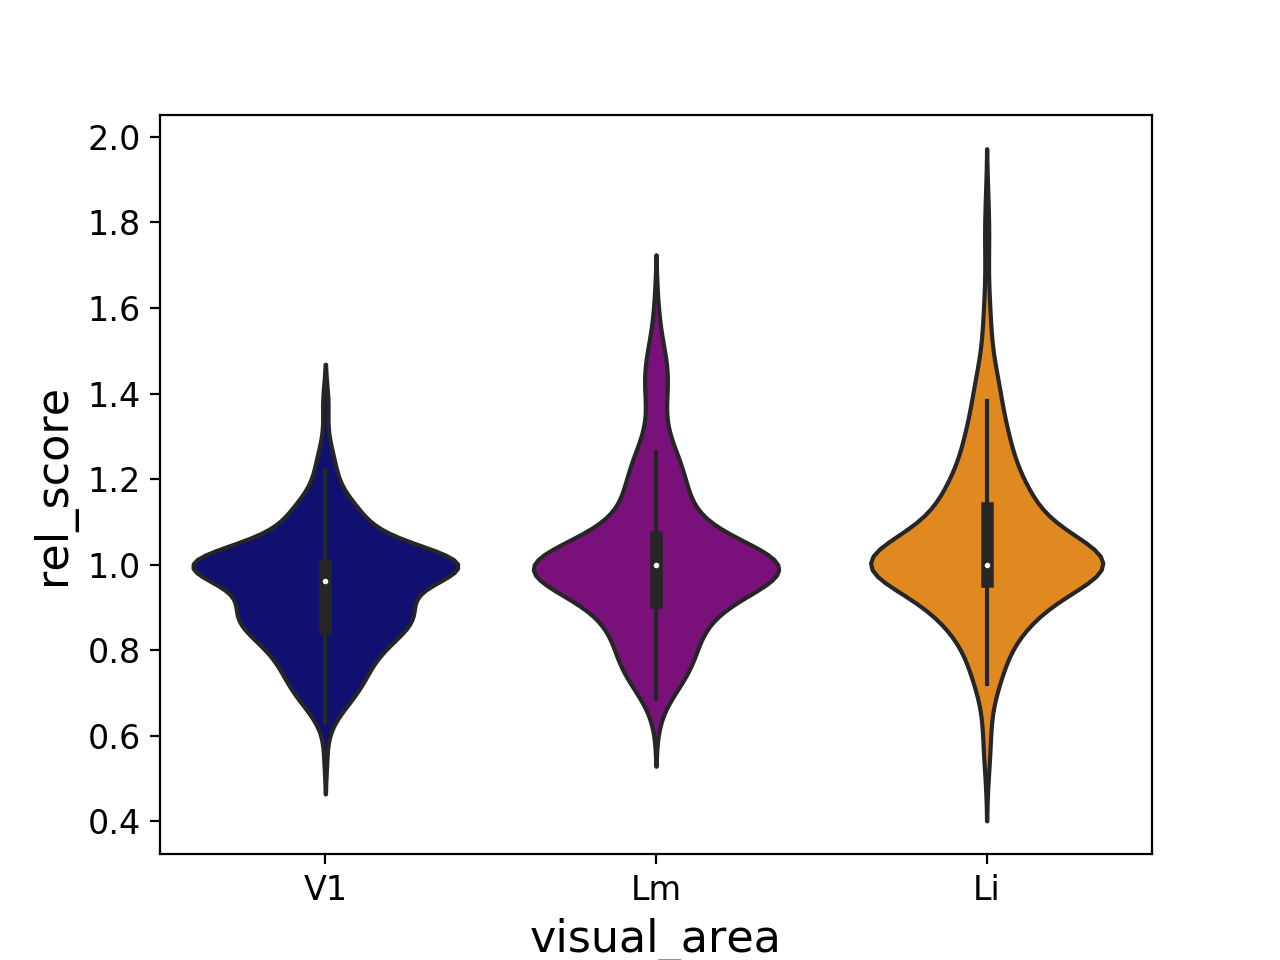

In [156]:
fig, ax = pl.subplots()
sns.violinplot(x='visual_area', y='rel_score', palette=area_colors, data=tdf, order=visual_areas, ax=ax) #, kind='box')
#sns.boxplot(x='visual_area', y='rel_score', palette=area_colors, data=tdf, order=visual_areas, ax=ax) #, kind='box')
#sns.swarmplot(x='visual_area', y='rel_score', color='k', data=tdf, order=visual_areas, ax=ax) #, kind='box')

In [ ]:
if run_:
    R = {}
    results={}

    for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):

        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        skey = '-'.join([animalid, session, fov])

        if '-'.join([animalid, session]) in excluded_sessions:
            print("...skipping %s" % skey)
            continue

        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        sizes = np.array(sorted(sdf['size'].unique()))
        morphs = np.array(sorted(sdf['morphlevel'].unique()))

        n_sizes = len(sdf['size'].unique())
        n_morphs = len(sdf['morphlevel'].unique()) 
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            continue

        rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                     response_type=response_type, responsive_test=responsive_test,
                                     responsive_thr=responsive_thr, n_stds=n_stds)
        rstats = rstats['nframes_above']

        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        #stimdf = sdf[sdf['morphlevel'] != -1]


        sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                              index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
        sample_data = sample_data[rois_plot]
        sample_labels = np.array(sample_data.index.tolist())

        sdf = exp.data.sdf.copy()
        sdf = reformat_morph_values(sdf)



        #stimdf = sdf[sdf['morphlevel'] != -1]
        stimdf = sdf.copy()
        tested_sizes = sorted(sdf['size'].unique())
        tested_morphs = sorted(sdf['morphlevel'].unique())

        #% Specify train/test conditions:     
        class_name = 'morphlevel'
        class_types = [0, 106]
        restrict_transform = True
        constant_transform = 'size'

        C = 1e3
        m0 = 0
        m100 = 106
        #train_transform = 30.

        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2

        for train_transform in tested_sizes:
            if train_transform not in R.keys():
                R[train_transform] = {}

            # Get train configs
            train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                    & (stimdf[constant_transform]==train_transform))].index.tolist()

            # Get corresponding indices into data array
            train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

            # Get data and labels
            X = sample_data.iloc[train_ixs].values #[train_configs]
            y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

            # Select generalization-test set
            untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
            test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                                   & (stimdf[class_name].isin(class_types)) )].index.tolist()

            test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
            X_test = sample_data.iloc[test_ixs].values
            y_test_labels = sample_labels[test_ixs]
            test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()


            #% Train/validation split
            n_splits = len(X)
            kf = KFold(n_splits=n_splits)
            kf.get_n_splits(X)

            scores=[]
            test_scores = dict((tv, []) for tv in tested_sizes)

            for train_index, validate_index in kf.split(X):
                # Get current train/validate split data
                X_train, X_validate = X[train_index], X[validate_index]
                y_train, y_validate = y[train_index], y[validate_index]
                scaler = preprocessing.StandardScaler().fit(X_train)
                X_train_transformed = scaler.transform(X_train)

                # Fit SVM
                trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

                # Validate with held-out data
                X_validate_transformed = scaler.transform(X_validate)
                curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                y_pred = trained_svc.predict(X_validate_transformed)

                # Add current fold score
                test_scores[train_transform].append(curr_score)

                # Test (generalization) to each size...
                for test_transform in test_transforms:
                    curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                                     if stimdf[constant_transform][tl]==test_transform]

                    X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
                    y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
                    curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)

                    test_scores[test_transform].append(curr_score_test)
                    #print( test_transform, curr_score_test)
                    #y_pred_test = trained_svc.predict(X_test_transformed)
            results[skey] = test_scores

            R[train_transform][skey] = test_scores

    # Save
    with open(results_fn, 'wb') as f:
        pkl.dump(R, f, protocol=pkl.HIGHEST_PROTOCOL)


In [61]:
R

NameError: name 'R' is not defined

In [184]:

df = pd.concat(df, axis=0)
chance = pd.concat(chance, axis=0)



In [187]:
df.groupby(['n_units']).mean()

,fit_time,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
n_units,,,,,,,,
6,0.006038,0.000433,0.537819,-5193.061988,-0.850200,0.592349,-4580.367544,-0.631803
12,0.009596,0.000466,0.529808,-5283.073519,-0.882328,0.618066,-4291.411295,-0.528905
24,0.016815,0.000837,0.543280,-5131.701712,-0.828449,0.669747,-3710.717578,-0.322066
48,0.032725,0.000806,0.557090,-4976.533706,-0.773152,0.750165,-2807.144807,-0.000123
96,0.039304,0.000921,0.565081,-4886.753664,-0.741288,0.918488,-915.868672,0.673706


In [188]:
chance.groupby(['n_units']).mean()

,fit_time,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
n_units,,,,,,,,
6,0.005940,0.000414,0.503916,-5574.000132,-0.986113,0.566647,-4869.157084,-0.734845
12,0.009624,0.000460,0.501800,-5597.774470,-0.994677,0.593262,-4570.110306,-0.628384
24,0.017591,0.000853,0.500292,-5614.721518,-1.000638,0.639259,-4053.290363,-0.444173
48,0.039193,0.000873,0.501219,-5604.301816,-0.996834,0.705762,-3306.056350,-0.177886
96,0.052637,0.000982,0.500291,-5614.725539,-1.000545,0.845927,-1731.168416,0.383240


In [211]:
train_res = np.array([(g['train_accuracy'].mean(), spstats.sem(g['train_accuracy']))\
                      for n_units, g in df.groupby(['n_units'])])
test_res = np.array([(g['test_accuracy'].mean(), spstats.sem(g['test_accuracy']))\
                     for n_units, g in df.groupby(['n_units'])])

train_chance = np.array([(g['train_accuracy'].mean(), spstats.sem(g['train_accuracy']))\
                      for n_units, g in chance.groupby(['n_units'])])
test_chance = np.array([(g['test_accuracy'].mean(), spstats.sem(g['test_accuracy']))\
                      for n_units, g in chance.groupby(['n_units'])])

N_samples = np.array([n_units for n_units, g in df.groupby(['n_units'])])

In [217]:
[t[1] for t in test_chance]

[0.0011775012021419658,
 0.0013658403429293476,
 0.001420104602711806,
 0.0013666861694844384,
 0.0028921528389125673]

# Threshold RF-lum, Threshold Overlap-percentage

In [42]:
import itertools
import statsmodels as sm

def do_mannwhitney(mdf, metric='I_rs'):
    visual_areas = ['V1', 'Lm', 'Li']
    mpairs = list(itertools.combinations(visual_areas, 2))

    pvalues = []
    for mp in mpairs:
        d1 = mdf[mdf['visual_area']==mp[0]][metric]
        d2 = mdf[mdf['visual_area']==mp[1]][metric]

        # compare samples
        stat, p = spstats.mannwhitneyu(d1, d2)
        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
        pvalues.append(p)

    reject, pvals_corrected, _, _ = sm.stats.multitest.multipletests(pvalues, alpha=0.05, method='holm')
    results = []
    for mp, rej, pv in zip(mpairs, reject, pvals_corrected):
        results.append((mp, rej, pv))
    
    return results

In [13]:

# First get only Object A and B trials
# Pick objects based on lum-ratio criterion of >=0.8 for object pairs.

m0 = 0 #objectA
m100 = 53 #objectB #106
    

In [90]:
overlap_thr=0.25
luminance_thr=0.8
C_value = 1.0

do_correction = True


n_iterations = 50


In [ ]:
do_correction = True

i = 0
rfdf=[]
no_cells=[]
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    sdf =  NEURALDATA[datakey]['sdf'].copy()
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    # Select subset of data
    sample_labels = NEURALDATA[datakey]['data']['config'].copy()
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

    # Get labels
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    if do_correction:
        # Get ROIs with RF fits and threshold by lum-ratio
        curr_lumdf = lumdf[lumdf['datakey']==datakey]
        rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
        meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
        lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
        pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

        # Get ROIs with RF fits and threshold by overlap-percentage
        meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

        print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 
    else:
        curr_rois = [r for r in sample_data.columns]

    #NCELLS = len(curr_rois)
    if NCELLS == 0:
        no_cells.append(datakey)
        continue

    # if len(curr_rois) < NCELLS:
    #     too_few[NCELLS].append((datakey, len(roi_list)))
    #     continue

    results=[]; test_results=[];
    for iteration in np.arange(0, n_iterations):

        roi_indices = np.arange(0, len(curr_rois))
        np.random.shuffle(roi_indices)
        roi_list = curr_rois[roi_indices[0:NCELLS]]

        sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
        sample_labels = NEURALDATA[datakey]['data']['config'].copy()
        sdf =  NEURALDATA[datakey]['sdf'].copy()

        # First get only Object A and B trials
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
        data = sample_data.loc[included_trial_nums]
        targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        # Equalize df/f across neurons:  Normalize each neuron to have 
        # the same (zero) mean and (unit) SD across the Ms stimuli
        zdata = (data - data.mean()) / data.std()

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        chance_train_data=[]; chance_test_data=[];
        chance_train_labels=[]; chance_test_labels=[];
        for sz in sizes:
            curr_configs = sdf[sdf['size']==sz].index.tolist()
            curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
            xi = zdata.loc[curr_trials]
            yi = targets.loc[curr_trials]['label'].values
            train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
            train_data.append(train_x)
            test_data.append(test_x)
            train_labels.append(train_y)
            test_labels.append(test_y)
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        print(train_data.shape, train_labels.shape)
        test_data = np.vstack(test_data)
        test_labels = np.hstack(test_labels)
        #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

        #### Fit classifier
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())
        results.append(pd.DataFrame(iterdict, index=[iteration]))
        
        # Test with held-out data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)  
        test_results.append(test_score)
        
    ddf = pd.concat(results, axis=0)
    results_across_iters = dict(ddf.mean())
    results_across_iters.update({'datakey': datakey, 
                            'n_units': NCELLS, 
                            'visual_area': visual_area,
                            'heldout_test_score': np.mean(test_results)})
    
    rfdf.append(pd.DataFrame(results_across_iters, index=[i]))
    i+=1

rfdf = pd.concat(rfdf, axis=0)
rfdf.shape


RF-lum-thr: 0/0, Overlap-thr: 0/0
[Li, 20190422_JC076_fov1] 0 rois common to both.
RF-lum-thr: 2/4, Overlap-thr: 14/14
[Li, 20190502_JC076_fov1] 2 rois common to both.
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218,))
((218, 2), (218

((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
((240, 13), (240,))
RF-lum-thr: 17/46, Overlap-thr: 20/20
[Li, 20190612_JC099_fov1] 15 rois common to both.
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), (240,))
((240, 15), 

((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
((240, 8), (240,))
RF-lum-thr: 48/71, Overlap-thr: 62/62
[Lm, 20190508_JC083_fov1] 39 rois common to both.
((234, 39), (234,))
((234, 39), (234,))
((234, 39), (234,))
((234, 39), (234

((240, 17), (240,))
((240, 17), (240,))
((240, 17), (240,))
((240, 17), (240,))
((240, 17), (240,))
((240, 17), (240,))
((240, 17), (240,))
RF-lum-thr: 65/96, Overlap-thr: 86/86
[V1, 20190507_JC083_fov1] 65 rois common to both.
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), (240,))
((240, 65), 

In [37]:
no_cells

['20190422_JC076_fov1',
 '20191105_JC117_fov1',
 '20190504_JC078_fov1',
 '20190509_JC078_fov1']

In [38]:
rfdf.groupby(['visual_area']).count()

,datakey,fit_time,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
visual_area,,,,,,,,,,,
Li,12,12,12,12,12,12,12,12,12,12,12
Lm,9,9,9,9,9,9,9,9,9,9,9
V1,11,11,11,11,11,11,11,11,11,11,11


## Plot results

In [39]:


visual_areas = ['V1', 'Lm', 'Li']
color_list = ['navy', 'darkmagenta', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

In [40]:
lumdir = os.path.join(aggregate_dir, 'luminance-analysis')

In [41]:
C_value, overlap_thr, luminance_thr

(0.5, 0.25, 0.8)

<IPython.core.display.Javascript object>


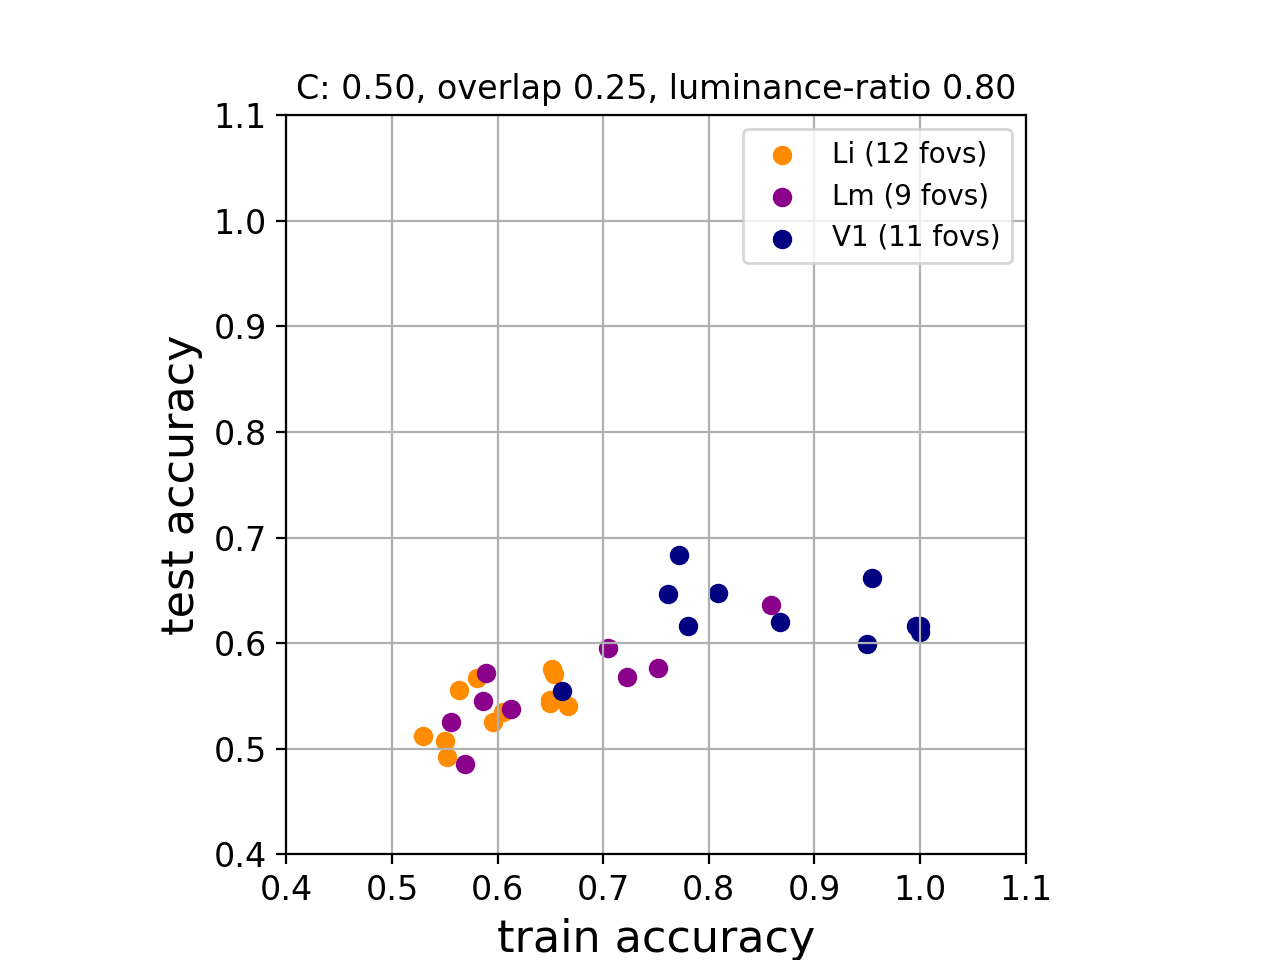

In [42]:
fig, ax = pl.subplots()
for visual_area, g in rfdf.groupby(['visual_area']):
    
    ax.scatter(g['train_accuracy'], g['test_accuracy'], color=area_colors[visual_area],
              label='%s (%i fovs)' % (visual_area, len(g['train_accuracy'])))

ax.set_title("C: %.2f, overlap %.2f, luminance-ratio %.2f" % (C_value, overlap_thr, luminance_thr))
ax.set_xlabel('train accuracy')
ax.set_ylabel('test accuracy')
ax.set_xlim([0.4, 1.1])
ax.set_ylim([0.4, 1.1])
ax.set_aspect('equal')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.0, 1))

pl.savefig(os.path.join(lumdir, 'linear-sep_population-analysis_C%.2f_filtered-lum-%.2f-overlap-%.2f.svg' % (C_value, luminance_thr, overlap_thr)))


In [30]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/linear-separability'

In [43]:
rfdf.groupby(['visual_area']).mean()

,fit_time,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
visual_area,,,,,,,,,,
Li,0.006752,0.533271,10.500000,0.000411,0.539053,-1294.800029,-0.845650,0.603843,-1112.804772,-0.586133
Lm,0.008650,0.567109,19.555556,0.000453,0.560107,-1235.659717,-0.761519,0.661317,-951.360449,-0.356120
V1,0.020876,0.645766,66.272727,0.000679,0.624785,-1053.978634,-0.502250,0.868252,-370.080573,0.472547


<IPython.core.display.Javascript object>


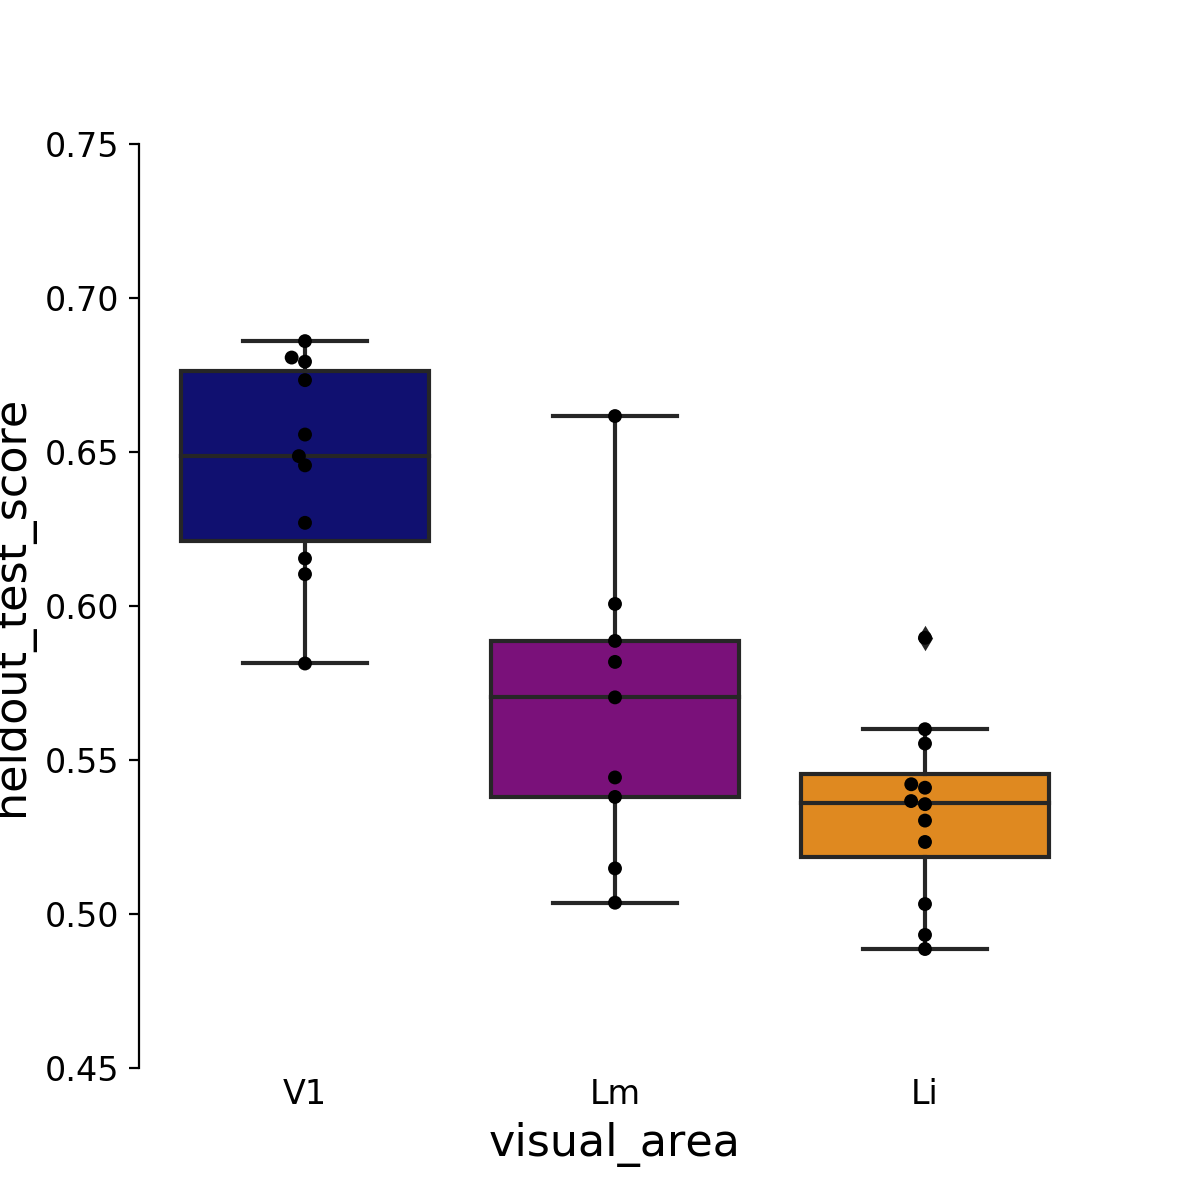

('/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis', 'mean-test-acc_linear-sep_population-analysis__C0.50_filtered-lum-0.80-overlap-0.25')


In [87]:
fig, ax = pl.subplots(figsize=(6,6))
sns.boxplot(x='visual_area', y='heldout_test_score', data=rfdf, # kind='box',
            palette=area_colors, order=visual_areas, ax=ax)
sns.swarmplot(x='visual_area', y='heldout_test_score', data=rfdf, # kind='box',
            color='k', order=visual_areas, ax=ax, alpha=1)
ax.set_ylim([0.45, 0.75])
ax.tick_params(axis='x', size=0)

sns.despine(bottom=True, offset=4)

figname = 'mean-test-acc_linear-sep_population-analysis__C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))

print(lumdir, figname)

In [55]:
res = do_mannwhitney(rfdf, metric='heldout_test_score')
res

Different distribution (reject H0)
Different distribution (reject H0)
Different distribution (reject H0)


[(('V1', 'Lm'), True, 0.0030468132560736378),
 (('V1', 'Li'), True, 0.00010794450671954485),
 (('Lm', 'Li'), True, 0.040829592218394162)]

<IPython.core.display.Javascript object>


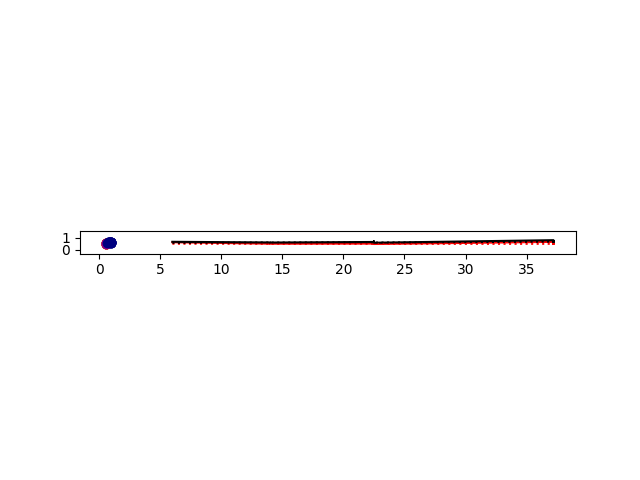

In [189]:
too_few=dict((nc, []) for nc in N_samples)

bootdf = []
i = 0
for NCELLS in N_samples:

    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

        sdf =  NEURALDATA[datakey]['sdf'].copy()
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        # Select subset of data
        sample_labels = NEURALDATA[datakey]['data']['config'].copy()
        included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
        sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

        # Get labels
        targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        # Get ROIs with RF fits and threshold by lum-ratio
        curr_lumdf = lumdf[lumdf['datakey']==datakey]
        rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
        meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
        lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
        pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

        # Get ROIs with RF fits and threshold by overlap-percentage
        meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = mean_overlaps[mean_overlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

        print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        print("%i rois common to both." % len(curr_rois))    


    
        if len(roi_list) < NCELLS:
            too_few[NCELLS].append((datakey, len(roi_list)))
            continue

        results=[]; chance_results=[];
        for iteration in np.arange(0, n_iterations):
            
            roi_indices = np.arange(0, len(roi_list))
            np.random.shuffle(roi_indices)
            roi_list = roi_list[roi_indices[0:NCELLS]]

            sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
            sample_labels = NEURALDATA[datakey]['data']['config'].copy()
            sdf =  NEURALDATA[datakey]['sdf'].copy()

            # First get only Object A and B trials
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
            data = sample_data.loc[included_trial_nums]
            targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (data - data.mean()) / data.std()

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            chance_train_data=[]; chance_test_data=[];
            chance_train_labels=[]; chance_test_labels=[];
            for sz in sizes:
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)
            train_data = np.hstack(train_data)
            train_labels = np.hstack(train_labels)
            test_data = np.hstack(test_data)
            test_labels = np.hstack(test_labels)
            #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))
            
            #### Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[iteration]))

        ddf = pd.concat(results, axis=0)
        results_across_iters = dict(ddf.mean())
        results_across_iters.update({'datakey': datakey, 'n_units': NCELLS})
        
        bootdf.append(pd.DataFrame(results_across_iters, index=[i]))
        
        i += 1
        



In [159]:
test_acc_shuff

array([ 0.50139083,  0.50329157,  0.50544713,  0.50247582,  0.49863035,
        0.49396038,  0.50136633,  0.50854252,  0.49526806,  0.51705726,
        0.50207414,  0.49547717,  0.4965973 ,  0.50682371])

In [160]:
df.groupby(['datakey']).mean()['n_units']

datakey
20190422_JC076_fov1    10
20190502_JC076_fov1    10
20190602_JC091_fov1    10
20190605_JC090_fov1    10
20190606_JC091_fov1    10
20190607_JC091_fov1    10
20190609_JC099_fov1    10
20190612_JC099_fov1    10
20190614_JC091_fov1    10
20190617_JC099_fov1     9
20191008_JC091_fov1    10
20191018_JC113_fov1    10
20191105_JC117_fov1    10
20191111_JC120_fov1    10
Name: n_units, dtype: int64

In [161]:
chance.groupby(['datakey']).mean()['n_units']

datakey
20190422_JC076_fov1    10
20190502_JC076_fov1    10
20190602_JC091_fov1    10
20190605_JC090_fov1    10
20190606_JC091_fov1    10
20190607_JC091_fov1    10
20190609_JC099_fov1    10
20190612_JC099_fov1    10
20190614_JC091_fov1    10
20190617_JC099_fov1     9
20191008_JC091_fov1    10
20191018_JC113_fov1    10
20191105_JC117_fov1    10
20191111_JC120_fov1    10
Name: n_units, dtype: int64

#### Chnce performance?

In [133]:
chance = []
for (animalid, session, fovnum), g in dsets[dsets['visual_area']=='Li'].groupby(['animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    roi_list = [r for r in NEURALDATA[datakey]['data'].columns.tolist() if r != 'config']
    sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
    sample_labels = NEURALDATA[datakey]['data']['config'].copy()
    sdf =  NEURALDATA[datakey]['sdf'].copy()

    # First get only Object A and B trials
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    data = sample_data.loc[included_trial_nums]
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    # Equalize df/f across neurons:  Normalize each neuron to have 
    # the same (zero) mean and (unit) SD across the Ms stimuli
    zdata = (data - data.mean()) / data.std()

    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    results=[]
    for iteration in np.arange(0, n_iterations):
        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[];
        train_labels=[]; test_labels=[];
        for sz in sizes:
            curr_configs = sdf[sdf['size']==sz].index.tolist()
            curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
            xi = zdata.loc[curr_trials]
            yi = targets.loc[curr_trials]['label'].values
            np.random.shuffle(yi)

            train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)

            train_data.append(train_x)
            test_data.append(test_x)
            train_labels.append(train_y)
            test_labels.append(test_y)

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        test_data = np.vstack(test_data)
        test_labels = np.hstack(test_labels)
        #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

        #### Train SVM:
        #trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        #train_scores.append(trained_svc.score(train_data, train_labels))

        #### Validate:
        #test_score = trained_svc.score(test_data, test_labels)  
        #crossval_scores.append(curr_score)
        #predicted_labels = trained_svc.predict(test_data)

        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())
        results.append(pd.DataFrame(iterdict, index=[iteration]))
    
    ddf = pd.concat(results, axis=0)
    ddf['datakey'] = [datakey for _ in np.arange(0, ddf.shape[0])]
    ddf['n_units'] = [len(roi_list) for _ in np.arange(0, ddf.shape[0])]
    chance.append(ddf)

In [134]:
chance = pd.concat(chance, axis=0)


<IPython.core.display.Javascript object>


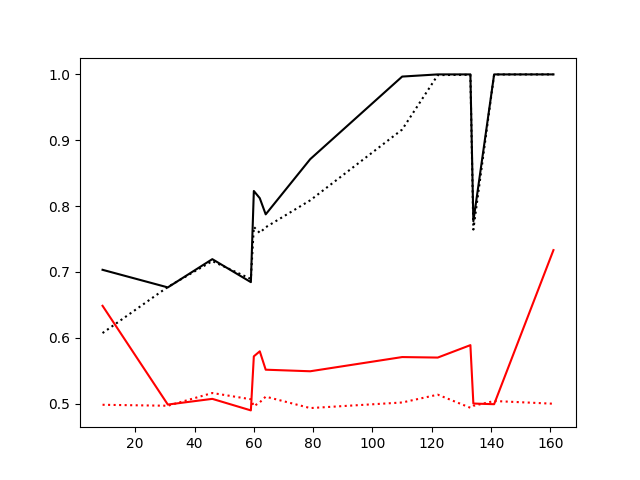

In [135]:
num_cells = df.groupby(['datakey']).mean()['n_units'].values
test_acc = df.groupby(['datakey']).mean()['test_accuracy'].values
train_acc = df.groupby(['datakey']).mean()['train_accuracy'].values
sort_ixs = np.argsort(num_cells)

fig, ax = pl.subplots()
ax.plot(num_cells[sort_ixs], test_acc[sort_ixs], label='test', color='r')
ax.plot(num_cells[sort_ixs], train_acc[sort_ixs], label='train', color='k')

num_cells_shuff = chance.groupby(['datakey']).mean()['n_units'].values
test_acc_shuff = chance.groupby(['datakey']).mean()['test_accuracy'].values
train_acc_shuff = chance.groupby(['datakey']).mean()['train_accuracy'].values
sort_ixs_shuff = np.argsort(num_cells_shuff)

ax.plot(num_cells_shuff[sort_ixs_shuff], test_acc_shuff[sort_ixs_shuff], 
        label='test-shuffled', color='r', linestyle=':')
ax.plot(num_cells_shuff[sort_ixs_shuff], train_acc_shuff[sort_ixs_shuff], 
        label='train-shuffled', color='k', linestyle=':')


In [139]:
df[df['n_units']>=60].mean()

fit_time                           0.038771
score_time                         0.000906
test_accuracy                      0.571392
test_neg_mean_squared_error    -4815.837236
test_r2                           -0.715991
train_accuracy                     0.906727
train_neg_mean_squared_error   -1048.015660
train_r2                           0.626621
n_units                          106.600000
dtype: float64